# Прогнозирование оттока в фитнес-клубе «Культурист-датасаентист».

## Описание проекта.
Сеть фитнес-центров «Культурист-датасаентист» разрабатывает стратегию взаимодействия с клиентами на основе аналитических данных. Основная проблема - отток клиентов. Нужно:
  - научиться прогнозировать отток на основе данных за предыдущий месяц;
  - сформировать типичные портреты клиентов, выделив несколько ярких групп;
  - проанализировать основные признаки, наиболее сильно влияющие на отток;
  - предложить меры по снижению оттока;

## План работы:##

### 1. [Исследовательский анализ данных.](#1)
### 2. [Строим модель оттока.](#2)
### 3. [Кластеризация клиентов.](#3)
### 4. [Рекомендации.](#4)

In [1]:
# импорт библиотек
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import KMeans

# убираем предупреждения
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

## 1. Исследовательский анализ данных.
<a id='1'></a>

In [2]:
df = pd.read_csv('/datasets/gym_churn.csv')

In [3]:
display(df.info())
display(df.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
gender                               4000 non-null int64
Near_Location                        4000 non-null int64
Partner                              4000 non-null int64
Promo_friends                        4000 non-null int64
Phone                                4000 non-null int64
Contract_period                      4000 non-null int64
Group_visits                         4000 non-null int64
Age                                  4000 non-null int64
Avg_additional_charges_total         4000 non-null float64
Month_to_end_contract                4000 non-null float64
Lifetime                             4000 non-null int64
Avg_class_frequency_total            4000 non-null float64
Avg_class_frequency_current_month    4000 non-null float64
Churn                                4000 non-null int64
dtypes: float64(4), int64(10)
memory usage: 437.6 KB


None

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
count,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000
mean,0.510250,0.845250,0.486750,0.308500,0.903500,4.681250,0.412250,29.184250,146.943728,4.322750,3.724750,1.879020,1.767052,0.265250
std,0.499957,0.361711,0.499887,0.461932,0.295313,4.549706,0.492301,3.258367,96.355602,4.191297,3.749267,0.972245,1.052906,0.441521
min,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,18.000000,0.148205,1.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,27.000000,68.868830,1.000000,1.000000,1.180875,0.963003,0.000000
50%,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,29.000000,136.220159,1.000000,3.000000,1.832768,1.719574,0.000000
75%,1.000000,1.000000,1.000000,1.000000,1.000000,6.000000,1.000000,31.000000,210.949625,6.000000,5.000000,2.536078,2.510336,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,12.000000,1.000000,41.000000,552.590740,12.000000,31.000000,6.023668,6.146783,1.000000


### Первичный взгляд на данные ###
1. В данных нет пропущенных значений. Все признаки заполнены для всех наблюдений.
2. Все типы данных числовые и соответствуют своим признакам.
3. Среднее значение признака gender = 0.51. Это значит, что соотношение полов в наших данных почти 50/50. Аномалий и выбросов нет.
4. Средний возраст клиентов - 29 лет. Самому младшему посетителю клуба - 18 лет, старшему - 41 год. 3/4 посетителей не старше 31 года. Аномалий и выбросов нет.
5. 84% посетителей проживают или работают рядом с фитнес клуюбом.
6. Почти половина посетителей - сотрудники компаний партнёров.
7. 31% посетителей совершили свой первый визит по акции "Приведи друга".
8. У 90% посетителей известен телефон.
9. Групповые занятия посещиают не все - 41% посетителей.
10. Минимальный аббонемент - 1 месяц, максимальный - 12 месяцев. Средний - 4,7 месяцев. 
10. Данные по LifeTime и времени до окончания абоннемента выглядят адекватно. Есть абсолютно новые посетители, которые с клубом первый месяц (lifetime = 0) и до конца аббонемента у них 12 месяцев. Самый преданный клиент с клубом уже 31 месяц! В среднем 1 клиент на данны момент ходит в клуб на протяжении 3,7 месяцев. А большинство (75%) ходят в клуб не более 5 месяцев.
11. Данные по среднему количеству занятий в неделю за весь период и за последний месяц отличаются не сильно. В среднем это чуть меньше 2 занятий в неделю. Есть те, кто не ходит совсем и те, кто ходит 6 дней в неделю!
12. 26,5% клиентов, судя по данным, перестали ходить в зал (оттекли). Довольно много(

In [4]:
df.groupby('Churn').mean()

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month
Churn,,,,,,,,,,,,,
0,0.510037,0.873086,0.534195,0.353522,0.903709,5.747193,0.464103,29.976523,158.445715,5.283089,4.711807,2.024876,2.027882
1,0.510839,0.768143,0.355325,0.183789,0.902922,1.728558,0.268615,26.989632,115.082899,1.662582,0.990575,1.474995,1.044546


### Данные по группам ###
1. Мужчины и женщины одинаково склонны бросать фитнес.
2. Возраст тех, кто всё-таки бросает занятия чуть ниже, чем у тех, кто не попал в отток. 27 лет в среднем для группы оттока, простив 30 лет - для тех, кто продолжает.
3. Гораздо сильнее отличается средняя длительность аббонемента. Для отточных клиентов этот показатель меньше 2 месяцев. Для тех, кто продолжает - почти 6 месяцев. Кажется, тот, кто настроен серьёзно, сразу покупает аббонемент на долгиц срок. Или наоборот - аббонемент на долгий срок и уплаченные деньги сильнее мотивируют всё-таки продолжать заниматься.
4. Довольно существенно отличается и % посещающих групповые занятия. Для группы продолжающих этот % близок к среднему по всем данным, около 46%. Те, кто бросил занятия посещали групповы тренировки лишь в 26% случаев.
5. Те, кто остался в клубе в среднем тратят больше на другие услуги клуба.
6. Очень интересны данные по LifeTime. Для группы продолжающих этот показатель такой же, как и в общих данных. Но для группы отточных клиентов средний LifeTime = 1. Это значит, что в среднем отточные клиенты склонны бросить занятия в первый месяц тренировок.
7. Средннее количество тренировок в неделю отличается не сильно, но для отточной группы так же меньше. 2 занятия в неделю для тех, кто остаётся против 1,5 для отточной группы. Примечательно, что в отточной группе месячный показатель посещаемости ещё ниже, чем показатель за всё время посещения клуба. Значит перед тем как бросить тренировки клиенты начинают ещё реже ходить в клуб.

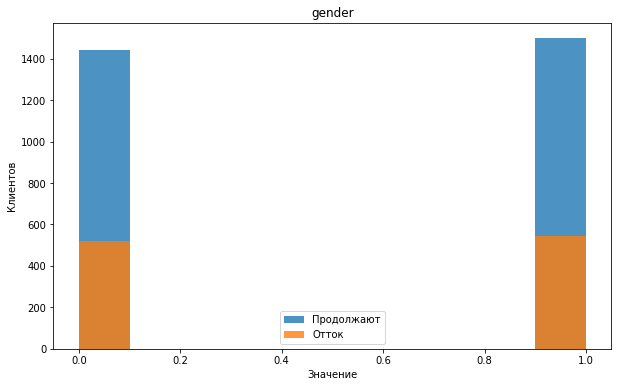

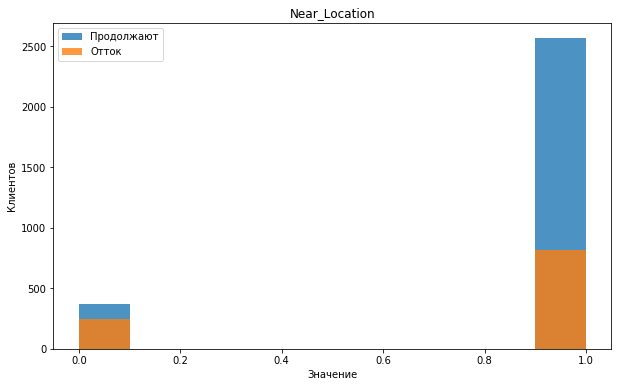

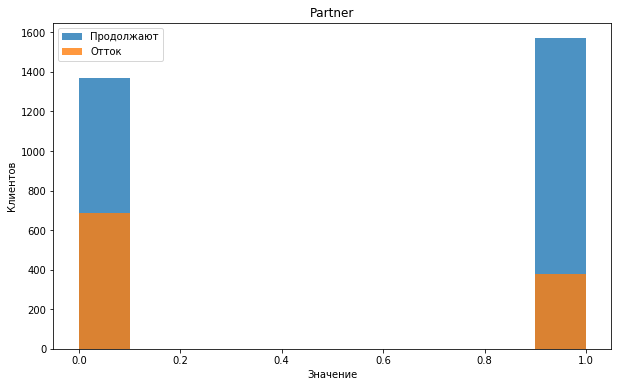

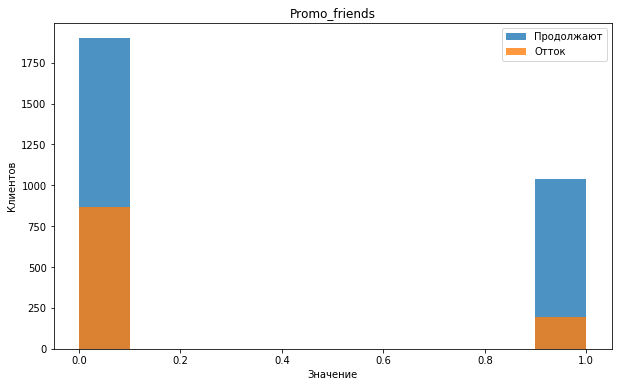

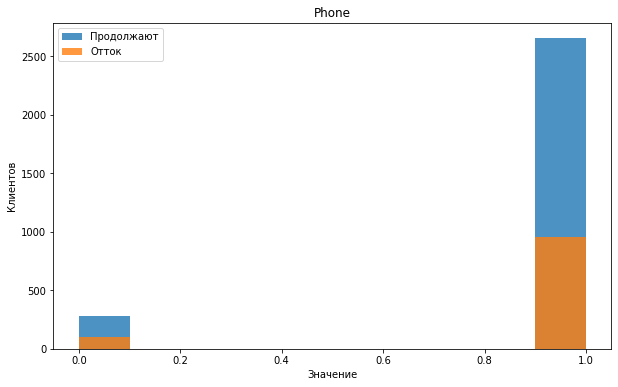

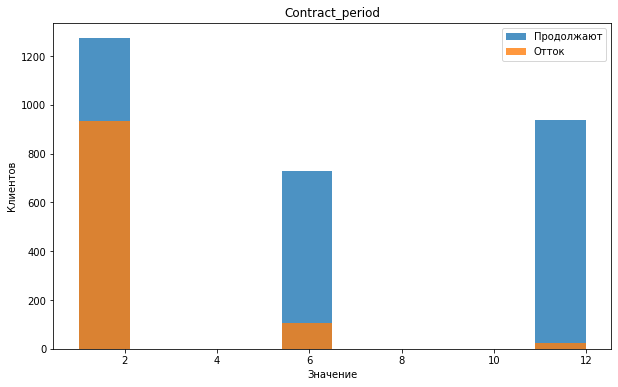

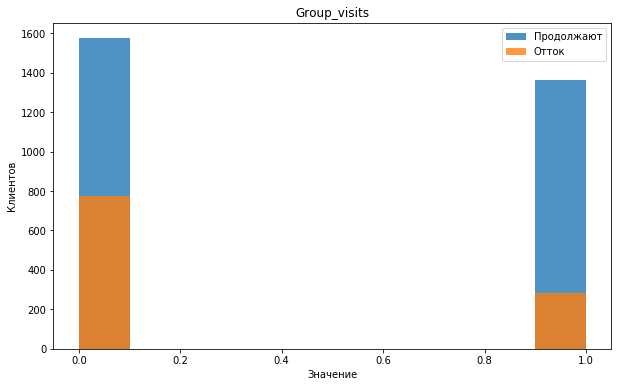

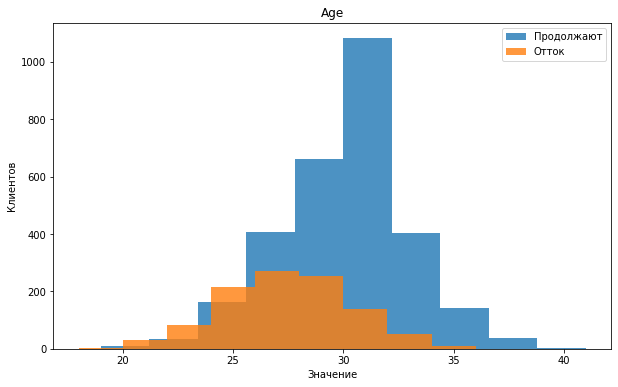

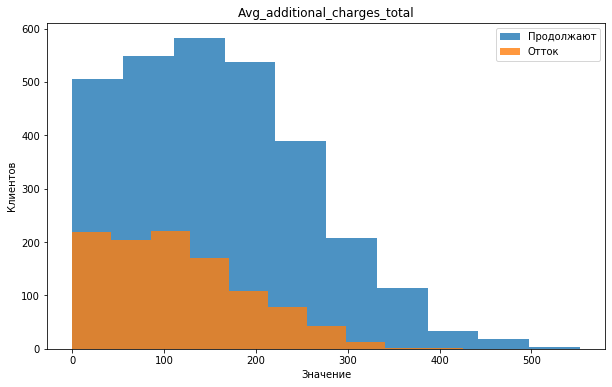

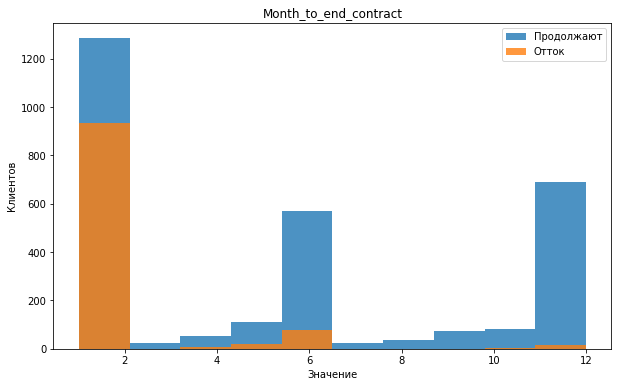

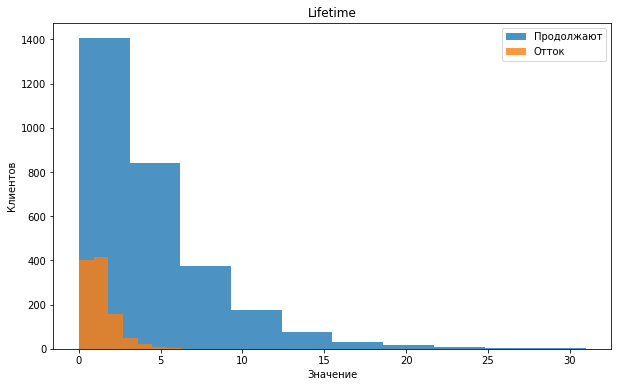

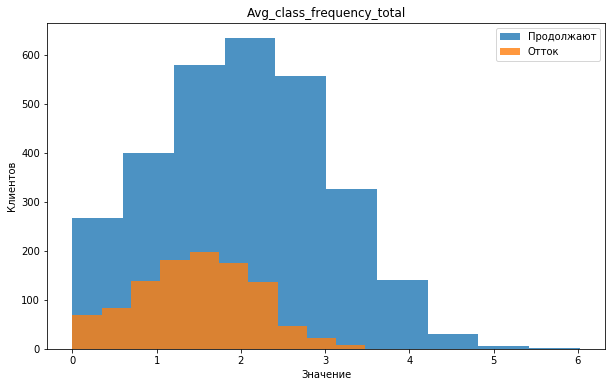

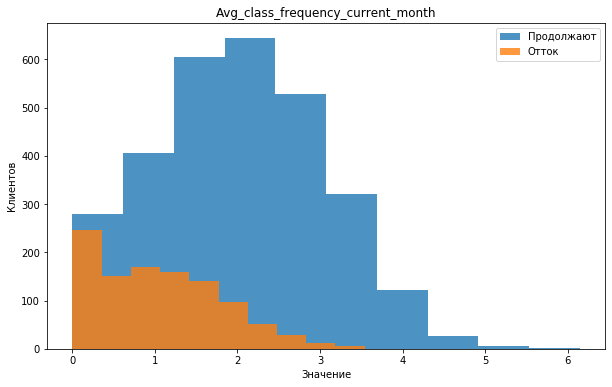

In [5]:
for col in df.drop('Churn', axis=1).columns:
    plt.figure(figsize=(10, 6)) 
    plt.title(col)
    plt.hist(df.query('Churn == 0')[col], alpha=0.8)
    plt.hist(df.query('Churn == 1')[col], alpha=0.8)
    plt.ylabel('Клиентов')
    plt.xlabel('Значение')
    plt.legend(['Продолжают', 'Отток'])
    plt.show()

### Взгляд на данные по гистограммам.

1. Гистограммы признаков со значениями 1/0 подтверждают наши предыдущие выводы.
2. Показатель возраста распределён близко к нормальному для обеих групп клиентов.
3. Гистограмма показателей LifeTime и выручки от других услуг имеет вид распределения Пуассона. Основываясь на предыдущем анализе это кажется логичным. Основная масса посетителей ходит в клуб не дольше 5 месяцев. Так же видно, что отточные клиенты сколнны меньше тратить на другие услуги клуба. Пик гистограммы и максимальное значение для этой группы меньше, чем для тех, кто продолжает тренировки.
4. Интересная картина для Среднего количество тренировок в неделю. Если смотреть на распределение этого показателя для всего периода, то для обоих групп распределение близко к нормальному. Но гистограмма этого же показателя отточной группы, но за последний месяц, сильно сдвигается влево и принимает вид распределения Пуассона. Это опять же позволяет предположить, что перед тем как бросить тренировки клиенты начинают ещё реже ходить в клуб.

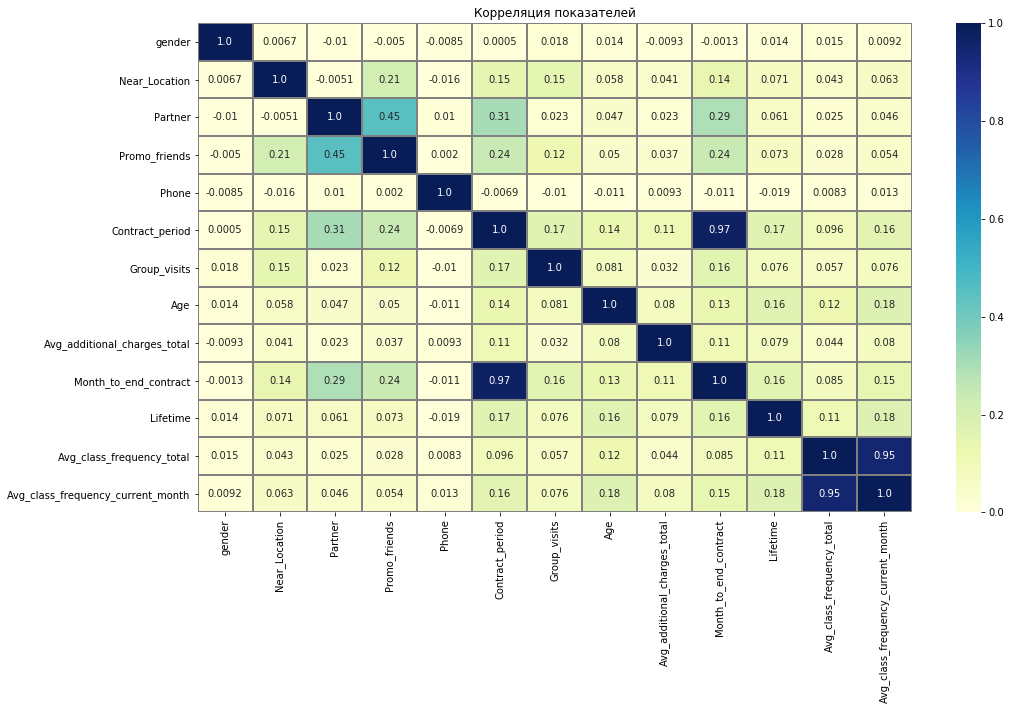

In [6]:
plt.figure(figsize=(16, 9))
plt.title('Корреляция показателей')
sns.heatmap(df.drop('Churn', axis=1).corr(), 
            annot=True, cmap="YlGnBu", 
            fmt='.2', 
            vmin=0, vmax=1, 
            linewidths=1, linecolor='gray', 
            robust=True
           )
plt.show()

### Анализ корреляций

Максимальная корреляция в двух парах показателей:

1. Длительность аббонемента и количество месяцев до конца периода. Логично, чем дольше аббонемент, тем больше месяцев до конца периода может быть. В этом случаем можно оставить только 1 показатель. Считаю, что лучше оставить - длительность аббонемента. Его проще интерпретировать и предыдущий анализ показал, что длительность аббонемента довольно сильно влияет на отток клиентов.
  
2. Среднее количество тренировок в неделю с начала аббонемента и за последний месяц. Это говорит о том, что в большинстве случаев клиенты сохраняют одинаковую частоту посещаемости на протяжении всего времени тренировок. На мой взгляд лучше оставить данные о регулярности тренировок за последий месяц. Пердыдущий анализ показал, что именно в этом показателе отточная группа сильнее отличается от тех, кто продолжает тренироваться.

In [7]:
# Удаляем указанные признаки

df.drop(['Avg_class_frequency_total', 'Month_to_end_contract'], axis=1, inplace=True)

### Данные загружены, проверены и очищены. Всё готово для построения моделей.

## 2. Строим модель оттока.
<a id='2'></a>

### а) Подготовим данные.

In [8]:
# разделим данные на признаки и целевую переменную (Сhurn)

X = df.drop('Churn', axis = 1)
y = df['Churn']

# разделяем модель на обучающую и валидационную выборку
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# стандартизируем данные 
scaler = StandardScaler()
scaler.fit(X_train)
X_train_st = scaler.transform(X_train)
X_test_st = scaler.transform(X_test)

### б) Строим модель методом логистической регрессии.

In [9]:
lr_model = LogisticRegression(random_state=0)

lr_model.fit(X_train_st, y_train)

lr_predictions = lr_model.predict(X_test_st)
lr_probabilities = lr_model.predict_proba(X_test_st)[:,1]

### в) Строим модель случайным лесом.

In [10]:
rf_model = RandomForestClassifier(random_state=0) 


rf_model.fit(X_train_st, y_train)

rf_predictions = rf_model.predict(X_test_st)
rf_probabilities = rf_model.predict_proba(X_test_st)[:,1]

### г) Сравниваем метрики.

In [11]:
# создаём функцию для вывода на экран метрик.

def print_all_metrics(y_true, y_pred, y_proba, title):
    print(title)
    print('\tAccuracy: {:.2f}'.format(accuracy_score(y_true, y_pred)))
    print('\tPrecision: {:.2f}'.format(precision_score(y_true, y_pred)))
    print('\tRecall: {:.2f}'.format(recall_score(y_true, y_pred)))
    print('-------------------------------------------------------------')

In [12]:
print_all_metrics(y_test, lr_predictions, lr_probabilities, 'Метрики логистической регрессии')
print_all_metrics(y_test, rf_predictions, rf_probabilities, 'Метрики случайного леса')

Метрики логистической регрессии
	Accuracy: 0.90
	Precision: 0.79
	Recall: 0.82
-------------------------------------------------------------
Метрики случайного леса
	Accuracy: 0.89
	Precision: 0.80
	Recall: 0.74
-------------------------------------------------------------


### Выводы на основе метрик.
1. По всем 2 метрикам лучше себя показала модель логистической регрессии, в точности лучше случайный лес.
2. Доля правильных ответов (Accuracy) для логистической регрессии на 1% выше, чем у случайного леса. Эта модель точнее определяет как отточных клиентов, так и тех, кто продолжает тренировки. В целом для обоих моделей этот показатель довольно высокий.
3. Точность (precision) логистической регрессии уступает случайному лесу на 1%.
4. Метрика полнота (recall) в логистической регресси превосходит случайный лес аж на 8%. С помощью этой можели нам удалось найти 82% всех отточных клиентов. Довольно неплохой показатель.

На мой взгляд для нашей цели наиболее важной метрикой является полнота. Нам важно найти всех клиентов, склонных к оттоку и работать с ними. При этом разница в точности всего 1%. Поэтому для построения модели лучше подходит логистическая регрессия.

## 3. Кластеризация клиентов.
<a id='3'></a>

### а) Строим матрицу расстояния.

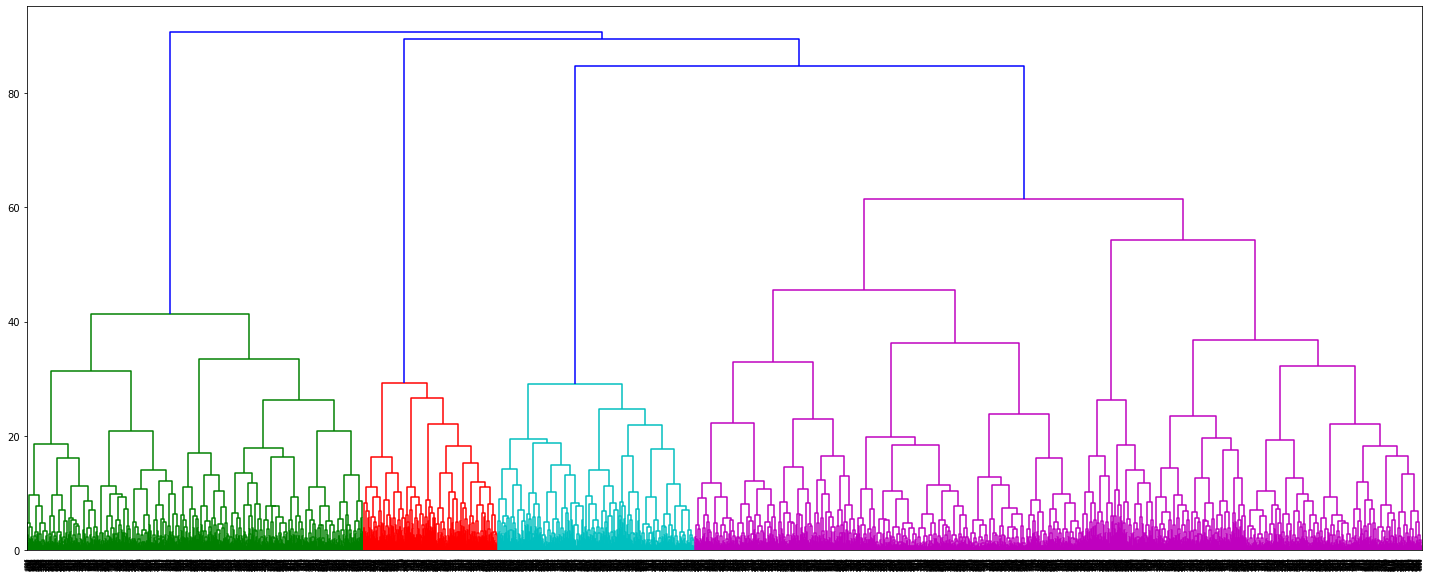

In [13]:
# стандартизируем матрицу признаков

sc = StandardScaler()
X_sc = sc.fit_transform(X)

# строим дендрограмму
linked = linkage(X_sc, method = 'ward') 
plt.figure(figsize=(25, 10))  
dendrogram(linked, orientation='top')
plt.show() 

### Вывод по графику.
Предложенное оптимальное число кластеров - четыре (4 разных цвета на дендрограмме). Но кластер фиолетового цвета занимает почти половину графика и разумно будет его разделить на 2 по верхней "ветви". Итого делим наши данные на 5 кластеров.

### Кластеризации на основании K-means.

In [14]:
km = KMeans(n_clusters = 5, random_state=0) # задаём число кластеров, равное 5
clusters = km.fit_predict(X_sc)

df['cluster'] = clusters
(df
 .groupby('cluster', as_index=False).mean()
 .merge(df.groupby('cluster', as_index=False)['gender'].count(), on='cluster')
 .rename({'gender_y':'count', 'gender_x':'gender'}, axis='columns')
)

,cluster,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Lifetime,Avg_class_frequency_current_month,Churn,count
0,0,0.496447,0.995939,0.892386,1.000000,1.0,6.922843,0.524873,29.606091,153.424651,4.283249,1.919520,0.119797,985
1,1,0.500000,0.000000,0.489247,0.078853,1.0,2.994624,0.232975,28.679211,137.125763,2.974910,1.597146,0.403226,558
2,2,0.500940,1.000000,0.217105,0.072368,1.0,2.010338,0.277256,27.583647,119.339956,1.922932,1.203319,0.563910,1064
3,3,0.534260,0.996028,0.379345,0.009930,1.0,6.208540,0.538232,30.699106,176.259567,5.415094,2.324220,0.014896,1007
4,4,0.523316,0.862694,0.471503,0.305699,0.0,4.777202,0.427461,29.297927,144.208179,3.940415,1.723967,0.266839,386


### Выводы по кластерам:

1. Первым делом смотрим на целевую переменную Churn. Явно выделяется кластер 2, в котором 56% клиентов ушли "в отток". Он довольно многочисленный - больше 1000 клиентов (1/4 наших данных). В кластере 1 также довольно высокий % оттока - 40%. 
В кластере 3 - самая низкая доля оттока - 1,5% и он тоже многочисленный (1007 клиентов). Довольно низкий % оттока и в кластре 0 - 12% клиентов. Интересно посмотреть как отличаются эти кластеры по другим признакам.


2. По всем бинарным признакам мы легко сможем посмотреть на долю по класерам:
  - Мужчины и женщиныы представлены примерно одинаково во всех кластерах (50/50);
  - По работе или проживанию в районе клуба сильно выделяется кластер 1 - в нём все клиенты живут далеко от фитнес-зала. Отметим, что доля оттока в этом кластре высокая. В остальных кластрах доля тех, кто живёт или работает рядом с залом очень высокая: 86% и выше.
  - Доля клиентов клубы, которые являются сотрудниками компаний-партнёров очень высокая в  кластере 0. Доля оттока там небольшая - 12%. При этом для кластера 2, сколнного к оттоку, доля сотрудников-партнёров самая низкая - 22% клиентов.
  - Примечательно, что 2 кластера с самым высоким % оттока выделяются и по признаку груповых занятий. В этих кластерах доля тех, кто посещает групповые тренировки 29% и ниже. Для остальных кластеров этот показатель 42% и выше.
  
  
3. Для анализа НЕбинарных признаков построим графики распределения.

In [15]:
df_test = df[['cluster', 
                 'Contract_period', 
                 'Age', 
                 'Avg_additional_charges_total', 
                 'Lifetime', 
                 'Avg_class_frequency_current_month']
               ]

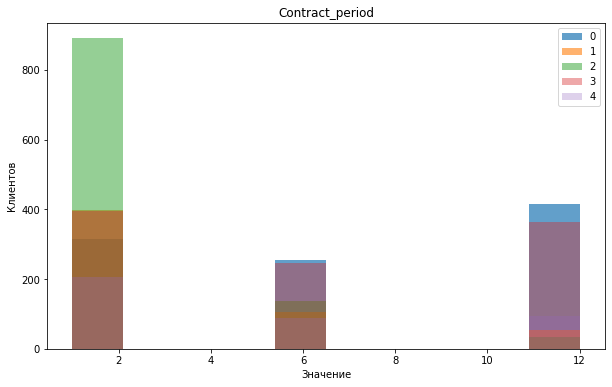

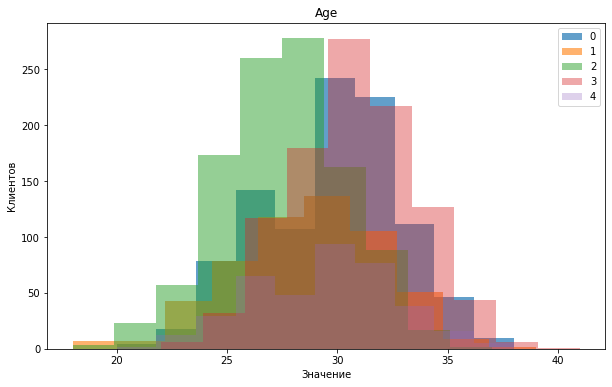

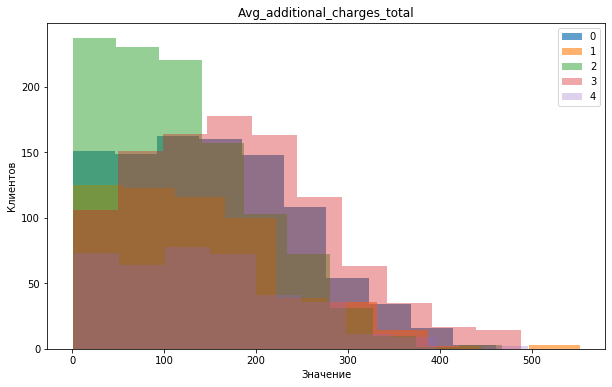

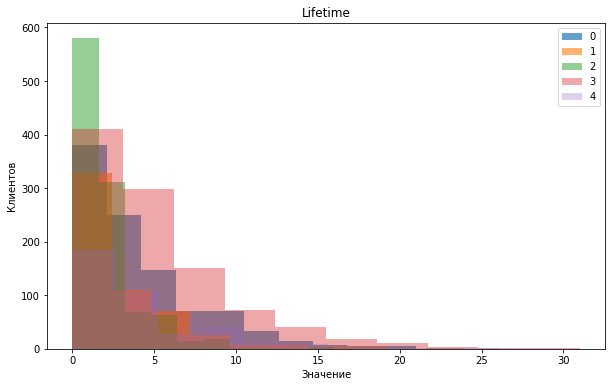

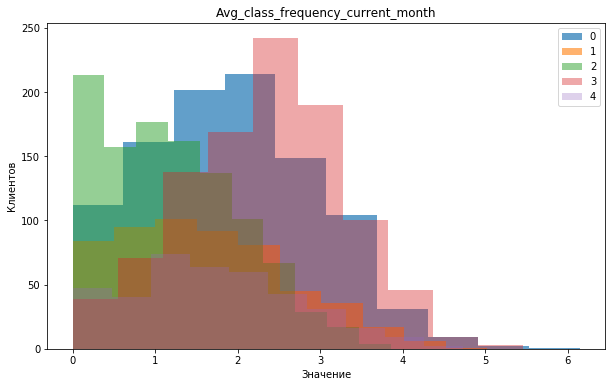

In [16]:
for col in df_test.drop('cluster', axis=1).columns:
    plt.figure(figsize=(10, 6)) 
    plt.title(col)
    plt.hist(df_test.query('cluster == 0')[col], alpha=0.7)
    plt.hist(df_test.query('cluster == 1')[col], alpha=0.6)
    plt.hist(df_test.query('cluster == 2')[col], alpha=0.5)
    plt.hist(df_test.query('cluster == 3')[col], alpha=0.4)
    plt.hist(df_test.query('cluster == 4')[col], alpha=0.3)
    plt.ylabel('Клиентов')
    plt.xlabel('Значение')
    plt.legend(['0', '1', '2', '3', '4'])
    plt.show()

### Выводы по графикам.

1. На гистограмме распределения длительности аббонемента явно выделяется кластер 2. В нём всех больше клиентов для которых длительность аббонемента минимально. Следом за ним идёт кластер 1. Отметим, что оба кластра имеют наибольшую долю отточных клиентов.

2. На гистограмме возраста пик кластера 2 находится левее других. Очевино клиенты в этом кластере моложе остальных. При этом пик кластера 3 (с наименьшей долей отточных клиентов) расположен правее. Клиенты в нём старше.

3. На гистограмме выручки от дургих покупок в клубе кластер 2 показывает пики на минимальных значениях. Эти клиенты не сколнны тратиться на сторонние покупки.

4. Гистограмма LifeTime показывает, что большинство клиентов самого "отточного" кластера тренируются первый месяц.

5. Клиенты из кластера 2, склонного к оттоку чаще всего ходят на тренировку 1 раз в неделю или реже. При этом пик гистограммы для кластера 3 между 2 и 3 тренировками в неделю.

## 4. Рекомендации.
<a id='4'></a>

1. Большиснтво клиентов склонны к оттоку именно в первый месяц тренировок. Важно основную работу по "борьбе" с оттокм вести именно с этой группой.


2. Данные показвают, что клиенты склонны к оттоку, если ходят редко (1 раз в неделю или реже) и не посещают групповые тренировки. В этом месте можно подумать над мотивационной программой, например, скидку тем, кто в течении первого месяца будет посещать 2-3 групповых тренировки в неделю.


3. Молодые клиенты больше сколнны к оттоку. Вместе с этим чаще перестают тренироваться те, кто меньше тратит на дополнительные услуги клуба. Предположу, что более молодые клиенты чаще всего менее платёжеспособны и для их удержания можно продумать более гибкую систему скидок. Например, скидка по студенческому.


4. Клиенты, которые пришли как сотрудники компаний-партнёров меньше склонны к оттоку. Эта группа как правило не нуждается в дополнительной мотивации.


5. Клиенты, купившие корткий аббонемент (на 1 месяц) уходят чаще, чем те, кто покупает аббонемент сразу на 6 или 12 месяцев. Возможно, дорогостоящая покупка сразу длительного аббонемента является дополнительным мотиватором. Поэтому можно делать более дешёвые аббонементы на длительный период. Делать это можно точечно, именно для клиентов, потенциально склонных к оттоку по другим признакм. Так же можно поэкспериментировать и попробовать абоннемент на 3 месяца. По цене он будет более доступным, но срок может мотивировать тренироваться чаще.